In [108]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
import sys
import os
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.collections import PathCollection

from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

from scipy.optimize import curve_fit

module_name = "utils_v2"
file_path = "/workspaces/TP3/utils_v2.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

# Importer le module
import utils_v2 as u

import pandas as pd

In [109]:
#import datas

Gases = ['AIR', 'HE']
Ns = [48, 33]

Vs=[[] for i in range(len(Gases))]
Ps=[[] for i in range(len(Gases))]
discharge_Vs = [[] for i in range(len(Gases))]

for i, (gas, N) in enumerate(zip(Gases, Ns)):
    for j in range(1, N + 1):
        # Load pressures from P.xlsx
        pressures_df = pd.read_excel(f'/workspaces/TP3/TP_Plasma/Datas/P_{gas}.xlsx', usecols=[1], header=None)

        # Get the corresponding pressure for the current file
        pressure_value = pressures_df.iloc[j - 1, 0]

        if isinstance(pressure_value, str) and pressure_value.lower() == "rien":
            continue
        else:
            if j < 10:
                data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/{gas}/{gas}000{j}.CSV', sep=';', decimal='.', header=21, usecols=[0, 1])
            else:
                data = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/{gas}/{gas}00{j}.CSV', sep=';', decimal='.', header=21, usecols=[0, 1])
            
            data_V = data.iloc[:, 0].to_numpy()

            # Convert into volts
            data_V = data_V * 1000

            Vs[i].append(data_V)
        
            # Convert pressure_value to a float
            pressure_value = float(pressure_value)
            Ps[i].append(pressure_value)

            discharge_Vs[i].append(np.max(data_V))
            


dt = 0.401






/workspaces/TP3/utils_v2.py:346: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(ncol = ncol, loc = loc)


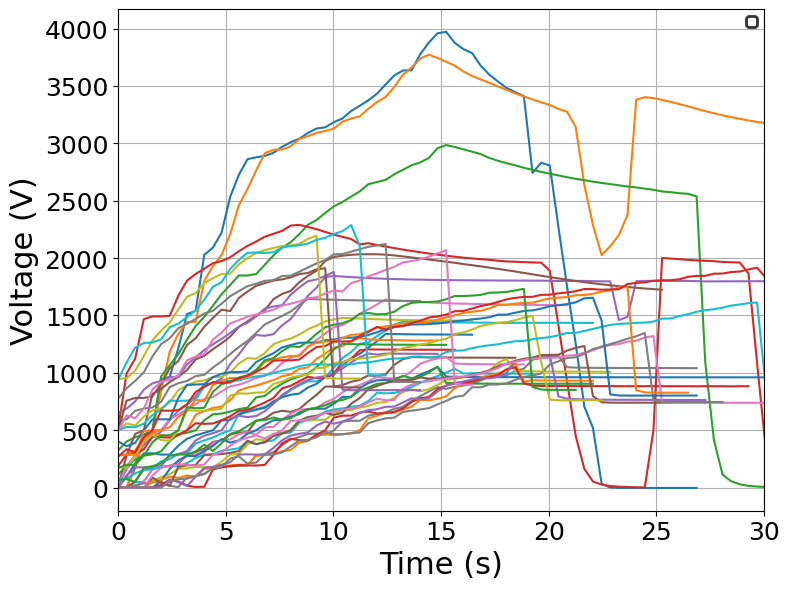

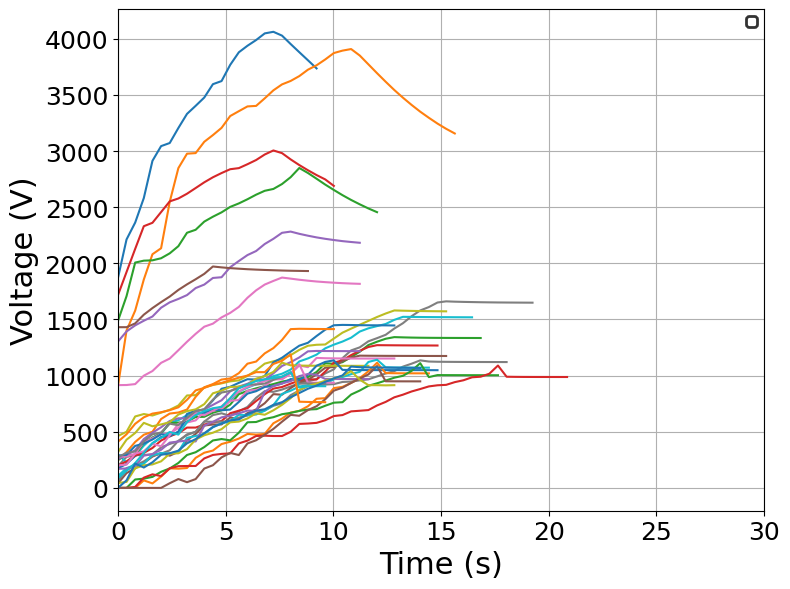

In [110]:
#plot
xlabel = "Time (s)"
ylabel = "Voltage (V)"

for g in range(len(Gases)):
    #plot for air
    ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)

    for i in range(len(Vs[g])):
        
        V = np.array(Vs[g][i])
        t = np.linspace(0, (len(V) - 1) * dt, len(V))

        # ax.plot(t,V, label=f'P = {Ps[i-1]} mbar')
        ax.plot(t,V)
        
        ax.set_xlim(0, 30)


    u.set_legend_properties(ax)
    plt.show()




## Plot the Paschen curve


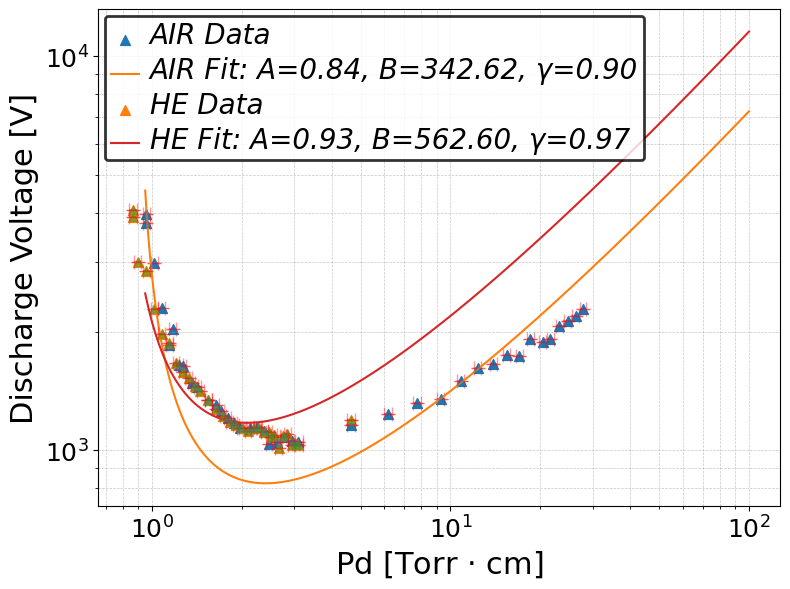

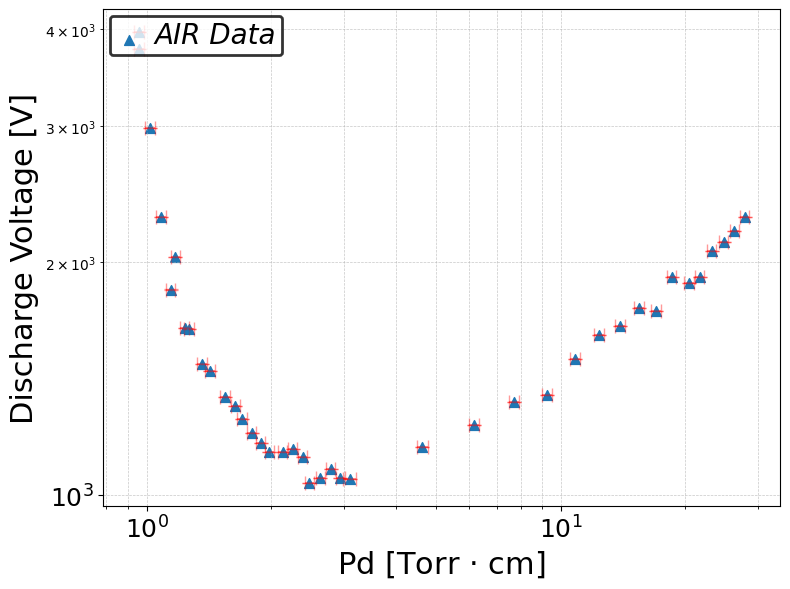

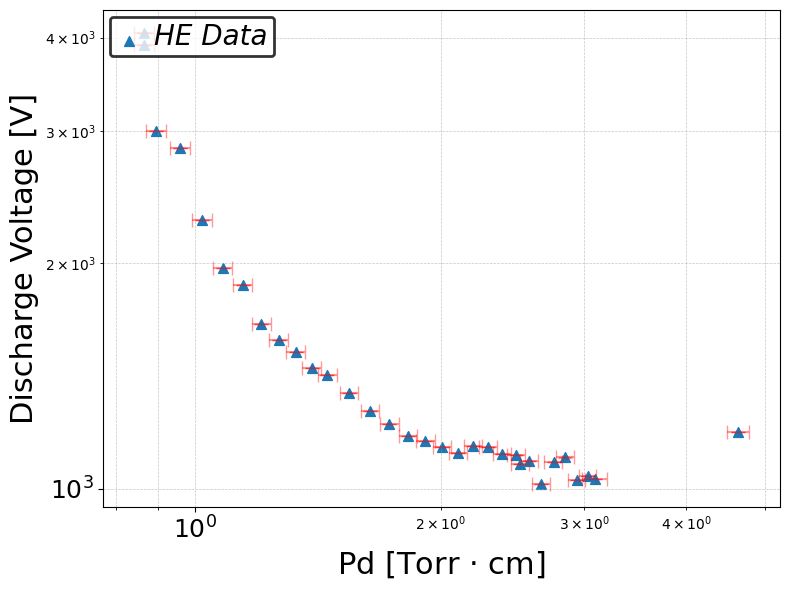

In [ ]:
#in cm, 1cm of error
d = 41.2
d_error = 1

Ps_error = [[] for i in range(len(Gases))]
Ps_torr = [[] for i in range(len(Gases))]
Ps_error_torr = [[] for i in range(len(Gases))]
pd_error = [[] for i in range(len(Gases))]
for g in range(len(Gases)):
    # Build the error on the pressure
    Ps_error[g] = np.array([0.1 * 10 ** (np.floor(np.log10(p)) - 1) for p in Ps[g]])

    Ps_error_torr[g] = Ps_error[g] * 0.75006

    # Convert pressure to Torr
    Ps_torr[g] = np.array(Ps[g]) * 0.75006

    # Calculate the error on pd
    pd_error[g] = Ps_torr[g] * d_error + Ps_error_torr[g] * d


# log_term = np.log(A * pd)
# inner_log = np.log(1 + 1/gamma)

# if np.any(log_term - np.log(inner_log) <= 0):  # Empêcher division par zéro ou log négatif
#     return np.inf

# if np.any((A * pd) <= 0) or np.any((1 + 1/gamma) <= 0):
#     return np.inf
    

#define the function for the fit ¨
def fit(pd, A, B, gamma):
    return B * pd / (np.log(A * pd) - np.log(np.log(1 + 1/gamma))) 



# Plot all gases in the same plot
ax, fig = u.create_figure_and_apply_format((8, 6), xlabel=r"Pd [Torr $\cdot$ cm]", ylabel="Discharge Voltage [V]")

for g in range(len(Gases)):
    # Scatter plot for each gas
    ax.scatter(Ps_torr[g] * d, discharge_Vs[g], label=f'{Gases[g]} Data', marker='^', s=50)
    ax.errorbar(Ps_torr[g] * d, discharge_Vs[g], xerr=pd_error[g], yerr=0.1, fmt='^', ecolor='red', capsize=5, alpha=0.4)

    # Fit and plot for each gas
    popt, pcov = curve_fit(fit, Ps_torr[g] * d, discharge_Vs[g], p0=[1, 1, 1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]), maxfev=10000)
    pd_fit = np.linspace(0.95, 100, 100000)
    # ax.plot(pd_fit, fit(pd_fit, *popt), label=f'{Gases[g]} Fit: A={popt[0]:.2f}, B={popt[1]:.2f}, γ={popt[2]:.2f}')


ax.set_xscale('log')
ax.set_yscale('log')
u.set_legend_properties(ax, loc="upper left")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

# Separate plots for each gas
for g in range(len(Gases)):
    ax, fig = u.create_figure_and_apply_format((8, 6), xlabel=r"Pd [Torr $\cdot$ cm]", ylabel="Discharge Voltage [V]")

    # Scatter plot for the current gas
    ax.errorbar(Ps_torr[g] * d, discharge_Vs[g], xerr=pd_error[g], yerr=0.1, fmt='^', ecolor='red', capsize=5, alpha=0.4)
    ax.scatter(Ps_torr[g] * d, discharge_Vs[g], label=f'{Gases[g]} Data', marker='^', s=50)
    
    # Fit and plot for the current gas
    popt, pcov = curve_fit(fit, Ps_torr[g] * d, discharge_Vs[g], p0=[1, 1, 1], bounds=([0, 0, 0], [np.inf, np.inf, np.inf]), maxfev=10000)
    pd_fit = np.linspace(0.95, 100, 100000)
    ax.plot(pd_fit, fit(pd_fit, *popt), label=f'{Gases[g]} Fit: A={popt[0]:.2f}, B={popt[1]:.2f}, γ={popt[2]:.2f}')

    ax.set_xscale('log')
    ax.set_yscale('log')
    u.set_legend_properties(ax, loc="upper left")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

    
